<a href="https://colab.research.google.com/github/KunalAyush1/PyTorch_learning/blob/main/PyTorch1_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

In [2]:
import torch
from torch import nn

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
#setting up a device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Using custom dataset
*We are going to make a model which predicts food upon looking*<br>
*Series of steps are as follows:*
##Load data
##Build a model
##Predict with the model


In [5]:
#version of pytorch

torch.__version__

'2.9.0+cpu'

##Getting the data

**Our dataset starts with 3 classes of food we have 100 images per class( 75 for training and 25 for teting)**


In [6]:
import requests
import zipfile
from pathlib import Path


#setup path to a data folder
data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

#if the image folder doesnt exist, download it and prepare it

if image_path.is_dir():
  print(f"{image_path} directory exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one....")
  image_path.mkdir(parents=True, exist_ok =True)

#Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, sushi data....")
  f.write(request.content)

#unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one....
Unzipping pizza, steak and sushi data...


# Data preparation and Data Exploration



In [7]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [9]:
#Setup train and test path

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Visualising an image

1. Get all of the image oaths
2. Pick a random image path using Python random.choice()
3. Get the image class name using pathlib.Path.parent.stem
4. Lets opne the image with Python's PIL
5. Then show the image and print metadata



data/pizza_steak_sushi/test/steak/1627703.jpg
steak
Random image path : data/pizza_steak_sushi/test/steak/1627703.jpg
Image class: steak
Image height: 512
Image width: 512


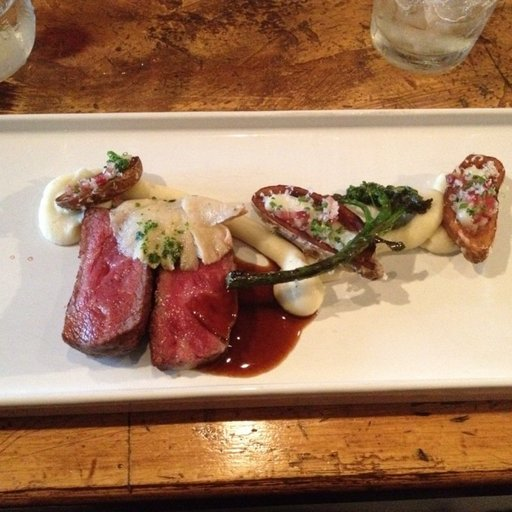

In [10]:
import random
from PIL import Image

random.seed(42)
#1.
image_path_list = list(image_path.glob("*/*/*.jpg"))
#2.
random_image_path = random.choice(image_path_list)
print(random_image_path)

#3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

#4. open image
img = Image.open(random_image_path)

#5. Getting metadata
print(f"Random image path : {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


# we can visualise an image using matplotlib

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

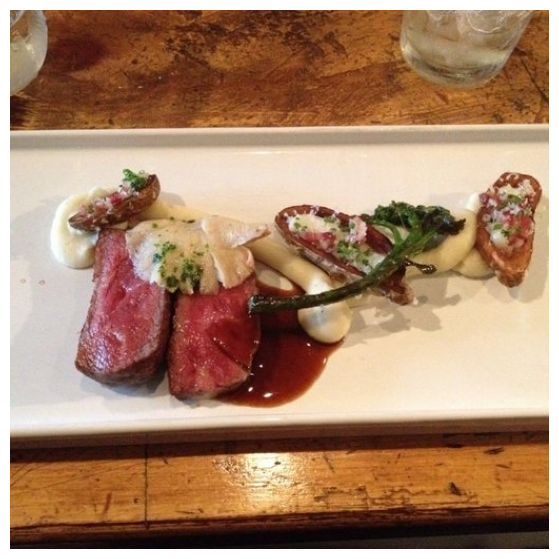

In [11]:
#using matplotlib for visualising

import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)

## Transforming data

1. Turn our target data into tensors
2. turn it into `torch.utils.data.Dataset` and `torch.utils.data.Dataloader`

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
data_transform = transforms.Compose([
    #Resize our images to (64,64)
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on horizontal(data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into torch.Tensor
    transforms.ToTensor()
    ])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

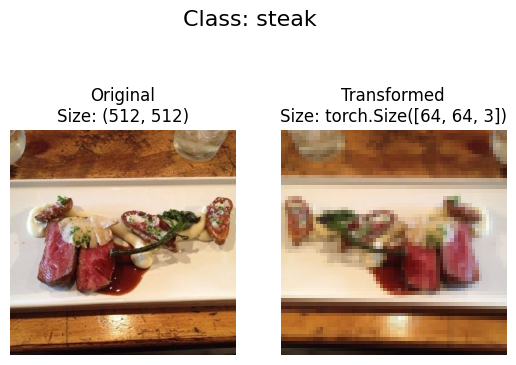

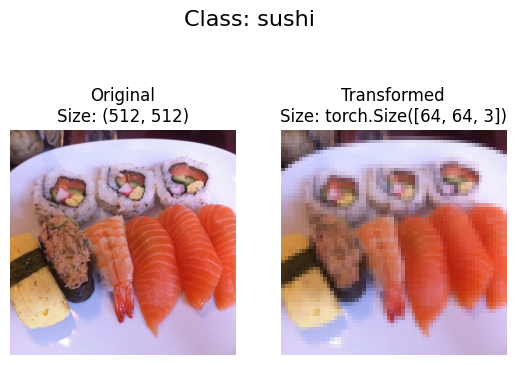

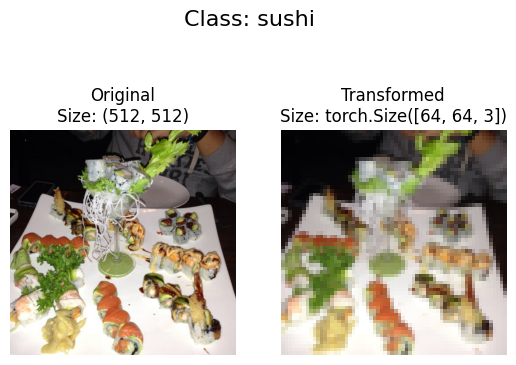

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols= 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # matplotlib takes color channels last but tensor has color channel first thats why we did permute
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

## Loading image data using `ImageFolder`

* We can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [18]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
len(train_data), len(test_data)

(225, 75)

In [21]:
# index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height,widht]
Image permute: [torch.Size([64, 64, 3]) -> [height, width, color_channels]]


Text(0.5, 1.0, 'pizza')

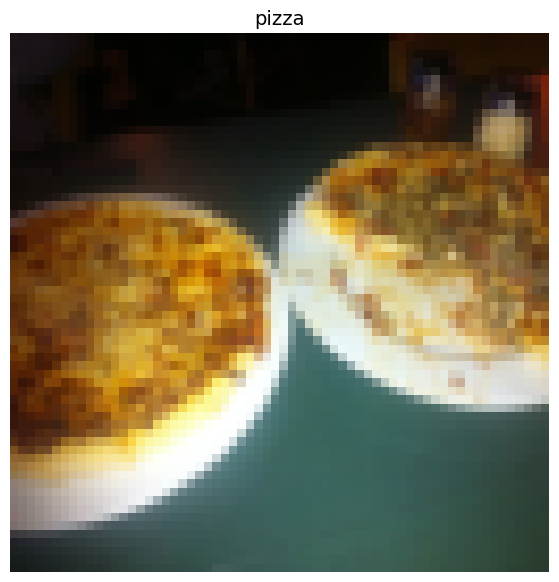

In [22]:
# rearrange the order dimension for matplotlib as color channel is last in matplotlib
img_permute = img.permute(1,2,0)

#printing different shapes
print(f"Original shape: {img.shape} -> [color_channels, height,widht]")
print(f"Image permute: [{img_permute.shape} -> [height, width, color_channels]]")

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

## Turning loaded images into DataLoader

A `DataLoader` is going to help our `dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [23]:
# turn train and test datasets into DataLoader(applicable for all kinds of data not only for images)
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c2b76cb2690>,
 <torch.utils.data.dataloader.DataLoader at 0x7c2b76d07500>)

In [24]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [25]:
img , label = next(iter(train_dataloader))


print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


#Data Augmentation

In [26]:
#Lets look at trivial augment,its used to increase model accuracy by augmenting

from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()

])

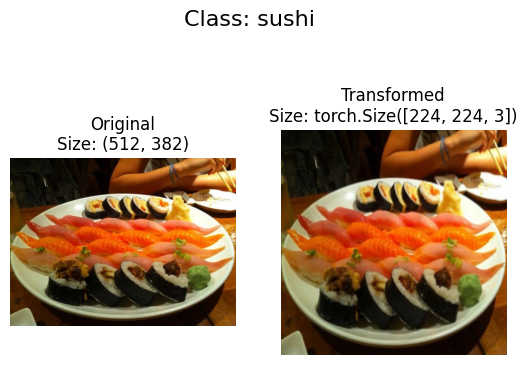

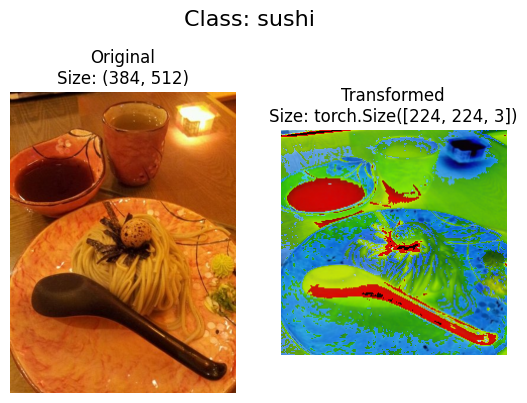

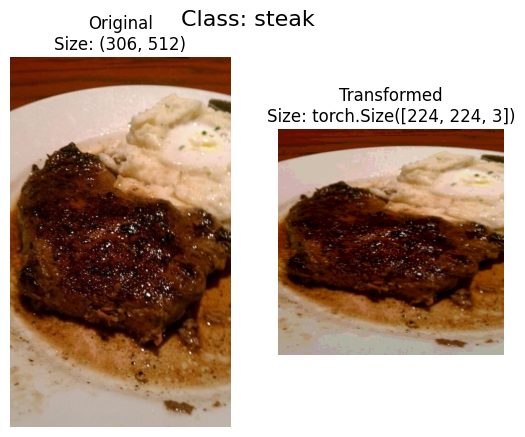

In [27]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

# Model0 : TinyVGG without data augmentation



In [28]:
#creating simple transform

simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64,64)),
                                                         transforms.ToTensor()

])

In [29]:
# Load the transform data

from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#create dataloader

train_dataloader_simple = DataLoader(dataset=train_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)


# Create TinyVGG model class

In [30]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) ## study about operator fusion

In [31]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # no of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

In [32]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#Try forward prop for a single image

In [33]:
#get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [34]:
#try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.9347e-02,  3.1597e-03,  7.4474e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.1068e-02, -2.6110e-03,  1.0277e-02],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 1.9275e-02, -1.7611e-04,  8.9663e-03],
        [ 1.9972e-02, -2.9622e-03,  8.2557e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2589e-02, -3.4084e-03,  1.0640e-02],
        [ 2.0182e-02, -2.1775e-03,  9.5757e-03],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 1.7433e-02

# Use `torchinfo` to get an idea of shapes

In [35]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, inout_size=[1,3,64,64])

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      5,073
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0

# Creating training and testing loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloaderr
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [36]:
# create a train loop

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: device):
  #put the model on train mode
  model.train()

  #setup train loss and train accuracy
  train_loss, train_acc = 0,0

  #loop through dataloader
  for batch, (X,y) in enumerate(dataloader):
    #send data to target device
    X, y = X.to(device), y.to(device)

    #Forward pass
    y_pred = model(X)

    #calculate loss

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backward

    loss.backward()

    #Optimoizer step
    optimizer.step()

    #calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  #adjusting metrics to get avg loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [37]:
#create a test loop
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device= device):
  #put model in eval mode
  model.eval()

  #setup test loss and test accuracy
  test_loss, test_acc = 0,0

  #turn on inference mode
  with torch.inference_mode():
    #loop through dataloader batches
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      #forward pass
      test_pred_logits = model(X)
      #loss calculation
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

  #calculate accuracy
  test_pred_labels = test_pred_logits.argmax(dim=1)
  test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  return test_loss, test_acc



### Creating a `train()` function to combine `train_step()` and `test_step()`

In [38]:
from tqdm.auto import tqdm

#1. create a tarin fn that takes in various model params + optimizer+ dataloaders + loss fn....
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device= device):
  #create empty result dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  #loop through training and testing steps for a no. of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader= train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model= model,
                                    dataloader= test_dataloader,
                                    loss_fn = loss_fn,
                                    device= device)
    #print
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    #update dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    #return results
  return results

### Train and evaluate model0

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

#timer start
from timeit import default_timer as timer
start_time = timer()

#train

model_0_results = train(model = model_0,
                        train_dataloader= train_dataloader_simple,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
#end the timer
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1064 | Train acc: 0.3125 | Test Loss: 3.2966 | Test acc: 0.0000
Epoch: 1 | Train loss: 1.1003 | Train acc: 0.3320 | Test Loss: 3.2089 | Test acc: 1.0000
Epoch: 2 | Train loss: 1.0881 | Train acc: 0.3633 | Test Loss: 3.2486 | Test acc: 0.6364
Epoch: 3 | Train loss: 1.0872 | Train acc: 0.3867 | Test Loss: 3.1791 | Test acc: 1.0000
Epoch: 4 | Train loss: 1.0667 | Train acc: 0.4062 | Test Loss: 3.2073 | Test acc: 0.7273
Total training time: 16.547 seconds


In [40]:
model_0_results

{'train_loss': [1.1063723713159561,
  1.1003402173519135,
  1.0881288647651672,
  1.0872400999069214,
  1.0666740387678146],
 'train_acc': [0.3125, 0.33203125, 0.36328125, 0.38671875, 0.40625],
 'test_loss': [3.296577215194702,
  3.208882689476013,
  3.248599648475647,
  3.179062247276306,
  3.207313656806946],
 'test_acc': [0.0, 1.0, 0.6363636363636364, 1.0, 0.7272727272727273]}

In [41]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### Plotting loss curve of Model 0

In [42]:
def plot_loss_curves(results: dict[str, list[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

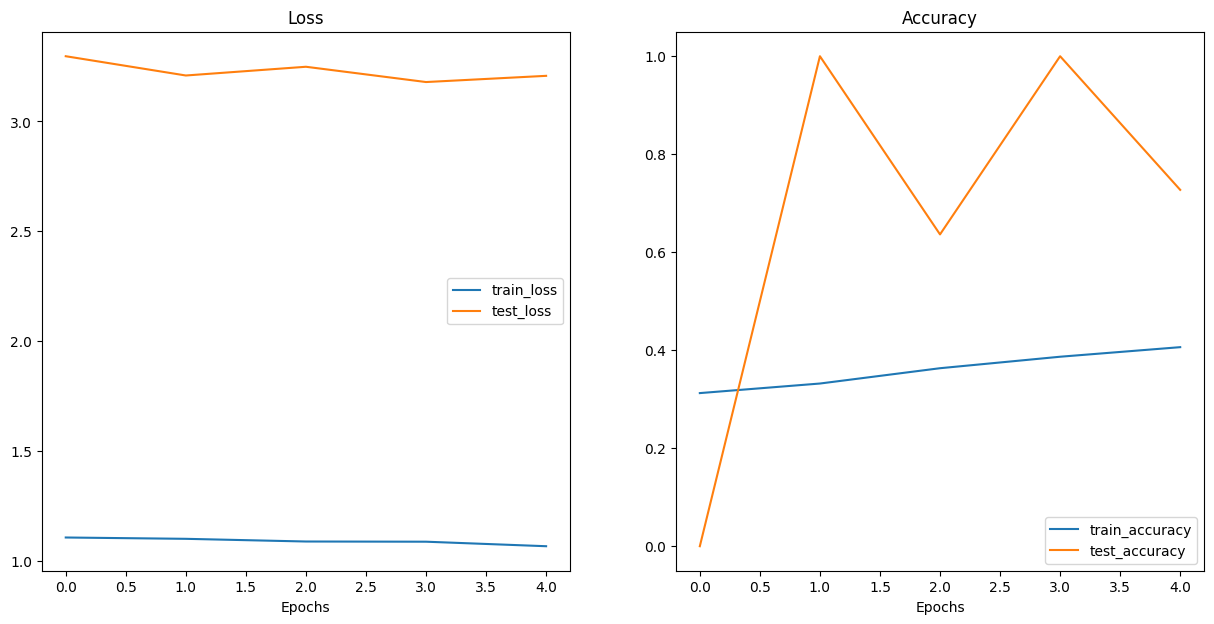

In [43]:
plot_loss_curves(model_0_results)

### Model1: TinyVGG with Data Augmentation

In [44]:
train_transform_trivial = transforms.Compose([
                                              transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
])

In [45]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [46]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader( dataset = train_data_augmented,
                                        batch_size= BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader( dataset = test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle=False,
                                     num_workers=NUM_WORKERS)

In [47]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [54]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9752 | Train acc: 0.5586 | Test Loss: 2.9987 | Test acc: 0.2727
Epoch: 1 | Train loss: 1.0135 | Train acc: 0.4648 | Test Loss: 3.2365 | Test acc: 0.1818
Epoch: 2 | Train loss: 0.8650 | Train acc: 0.5820 | Test Loss: 3.1452 | Test acc: 0.1818
Epoch: 3 | Train loss: 0.9240 | Train acc: 0.6211 | Test Loss: 3.1397 | Test acc: 0.1818
Epoch: 4 | Train loss: 0.8768 | Train acc: 0.6016 | Test Loss: 3.2245 | Test acc: 0.0909
Epoch: 5 | Train loss: 0.9390 | Train acc: 0.6094 | Test Loss: 3.3649 | Test acc: 0.1818
Epoch: 6 | Train loss: 0.8524 | Train acc: 0.6094 | Test Loss: 2.9570 | Test acc: 0.3636
Epoch: 7 | Train loss: 0.9146 | Train acc: 0.6055 | Test Loss: 2.9180 | Test acc: 0.3636
Epoch: 8 | Train loss: 0.9663 | Train acc: 0.4727 | Test Loss: 3.1227 | Test acc: 0.2727
Epoch: 9 | Train loss: 0.8674 | Train acc: 0.6250 | Test Loss: 2.8081 | Test acc: 0.6364
Epoch: 10 | Train loss: 0.8887 | Train acc: 0.6172 | Test Loss: 2.8776 | Test acc: 0.3636
Epoch: 11 | Train lo

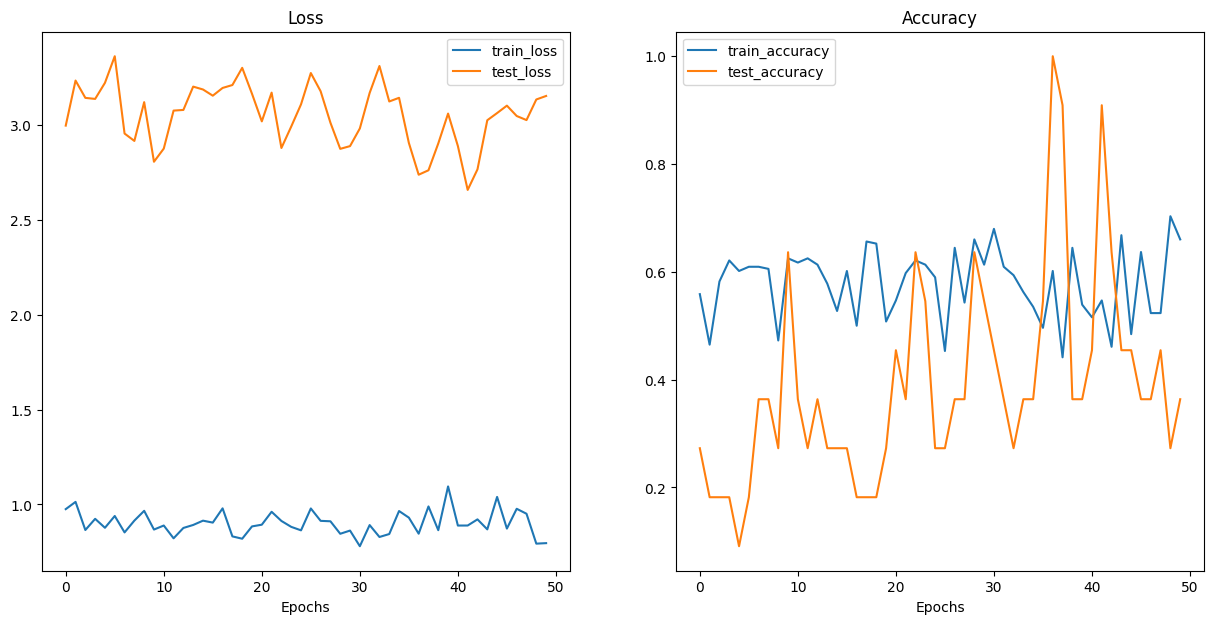

In [55]:
plot_loss_curves(model_1_results)